# Assignment 4 - Keyboard Analysis
By Nishanth Senthil Kumar (EE23B049)

## Some instructions before running this code
Please ensure that the input layouts for the keyboards are given as a python script(i.e a file with a .py extension), with the input dictionaries being named "keys" and "dictionaries" respectively. This script has to be present in the same directory. 

Please also ensure that matplotlib, numpy and scipy are installed in your system before running it, if not please install it using pip
(Note : All these libraries are there in the virtual juypter server hosted by sir)

Please run all the cells sequentially, if you change the input string, please run the whole program again to avoid any issues.

Importing necessary libraries

In [279]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.colors 
from scipy.interpolate import griddata

I require a "layout.py" file which contains the input dictionaries "keys" and "dictionary". They have to be named "keys" and "dictionaries" respectively. (Note : I have attached a layout.py file along with the submission, which has the same layout as the one in the 4th progamming quiz, question 3)

In [280]:
import layout as layout
keys=layout.keys
characters=layout.characters

Modify the input string if you want to

In [281]:
input_string="The quick brown fox jumped over the lazy dogs"

I have defined the key_height and key_width to be 1 unit each, as I have assumed the key size to be constant, irrespective of the coordinate system. If required, they can be changed here.

In [282]:
key_height=1
key_width=1

I am storing the maximum and minimum x and y coordinates that are present in the input layout, which will be of use later

In [283]:
x_min=1e9
x_max=0
y_min=1e9
y_max=0
for key in keys:
    x=keys[key]['pos'][0]
    y=keys[key]['pos'][1]
    if(x<x_min):
        x_min=x
    if(y<y_min):
        y_min=y
    if(x>x_max):
        x_max=x
    if(y>y_max):
        y_max=y

In [284]:
def update_heatmap(input_string):
    '''
    Input : The input string given by user
    Description : This function goes through the input string and updates the heatmap dictionary 
    with frequencies of each charater that is being typed. 
    Note : If a character that is not present in the layout, or a character whose mapping has not been given in the layout
    is present in the input string, it will raise a valueerror with the character at fault. If so, please check your input dictionaries. 
    '''
    heatmap=dict()
    for key in keys:
        heatmap[key]=0
    for char in input_string:
        if(char in keys):
            heatmap[char]+=1
        elif(char in characters):
            for i in characters[char]:
                heatmap[i]+=1

        else:
            raise ValueError(f"Invalid character {char}, Please check your input layout and add the required character and their mapping")

    return heatmap

In [285]:
def distance_calculation(input_string):
    '''
    Input : The input string given by user
    Description : This function calculates the distance travelled by the fingers from the home keys, if the key requires more than
    one key to be pressed, it will access the characters dictionary and find the mapping.
    If the entered characters is not defined in either the "keys" or "characters", ValueError will bw thown
    '''
    distance_travelled=0
    for char in input_string:
        if(char in keys):
            char_position=keys[char]['pos']
            home_key=keys[char]['start']
            home_position=keys[home_key]['pos']
            distance_travelled+=((char_position[0]-home_position[0])**2 + (char_position[1]-home_position[1])**2)**0.5

        elif(char in characters):
            for i in characters[char]:
                char_position=keys[i]['pos']
                home_key=keys[i]['start']
                home_position=keys[home_key]['pos']
                distance_travelled+=((char_position[0]-home_position[0])**2 + (char_position[1]-home_position[1])**2)**0.5
        else:
            raise ValueError(f"Invalid character {char}, Please check your input layout and add the required character and their mapping")

    return distance_travelled

In [286]:
def draw_keyboards(heatmap):
    '''
    Description : This function uses the heatmap data to make the keyboard layout and interpolates the color 
    based on the frequency values of neighboring keys.
    It normalises the frequency values from the heatmap dictionary to a number between 0 and 1 and chooses the 
    corresponding color from the colormap. It then performs interpolation to smoothen the transitions between keys.
    The output is two plots: one for individual key color, another with interpolation blending the colors.
    '''

    #I am using the least intense color of colormap "YLGn", provided by matplotlib, as the background of my plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
    cmap = cm.YlGn
    fig.patch.set_facecolor(cmap(0))

    max_hits = max(heatmap.values())
    min_hits = min(heatmap.values())
    
    norm = Normalize(vmin=min_hits, vmax=max_hits)
    cmap = cm.gist_rainbow

    def get_color(value, min_hits, max_hits):
        '''
        Input : value - frequency corresponding to the key
                min_hits - Minimum no of presses among all keys
                max_hist - Maximum no of presses among all keys
        Description : This function allots a color on the bottom half of the gist_rainbow colormap based on the no of times the key was pressed
        If the key was never pressed, I return white, which is the background of the keyboard. 
        Since I want only the bottom half of gist_rainbow, I normalise between 0 and 0.4.
        Returns : Array corresponding to the color it should have from the color map
        '''
        if value == 0:
            return (1, 1, 1)
        else:
            if max_hits != min_hits:
                norm_value = (value - min_hits) / (max_hits - min_hits)
                norm_value = 0.4 - norm_value * (0.4 - 0)
            else:
                norm_value = 0

            norm_value = np.clip(norm_value, 0, 0.4)
            return cmap(norm_value)

    key_coords = []
    key_colors = []
    
    #plotting the keyboard characters
    for key in keys:
        x = keys[key]['pos'][0]
        y = keys[key]['pos'][1]
        key_clean = key.strip()
        
        #this gets the color corresponding to the frequency of the character from the colormap
        base_color = get_color(heatmap.get(key_clean, 0), min_hits, max_hits)[:3]
        base_color = np.array(base_color).reshape(1, 1, 3)

        #The bg color of each key is white, so at the distance from the centre increaes, I want to make it fade into white
        #I use a gaussian filter to mix the base_color with white as the distance increases(learnt this in EE1103).
        #It generates a gradient_color matrix which is used by imshow to plot the colors
        x_grid, y_grid = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
        r = np.sqrt(x_grid**2 + y_grid**2)
        z = np.exp(-3 * r / 2).reshape(100, 100, 1)
        gradient_color = z * base_color + (1 - z) * np.array([1, 1, 1]).reshape(1, 1, 3)

        ax1.imshow(gradient_color, extent=[x, x + key_width, y, y + key_height], aspect='auto')

        rect = patches.FancyBboxPatch((x, y), key_width, key_height, boxstyle="round,pad=0.001", 
                                      linewidth=1.5, edgecolor='black', facecolor='none')
        ax1.add_patch(rect)
        ax1.text(x + key_width / 2, y + key_height / 2, key.strip(), 
                 fontsize=12, ha='center', va='center', color='black')
        
        key_coords.append([x + key_width / 2, y + key_height / 2])
        key_colors.append(heatmap.get(key_clean, 0))

    ax1.set_xlim(-2, 16)
    ax1.set_ylim(-2, 10)
    ax1.axis('off')


    #Since i am using only a part of gist_rainbow, I couldnt find a way to have a colorbar with only those values, so I made a custom colormap to make the colorbar
    custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "custom", ["white", "lightgreen", "yellow", "orange", "red"])
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    fig.colorbar(sm, ax=ax1, orientation='vertical', label='Key Press Frequency')

    #I am adding dummy keys across the border of the actual keyboard, I am doing this to avoid abrupt endings in the smoothening at the boundaries
    for i in range(int(x_min) - 1, int(x_max) + 1, key_width):  
        key_coords.append([i, y_min - 1])
        key_coords.append([i, y_max + 1])
        key_colors.append(0)  
        key_colors.append(0)
        key_coords.append([i, y_min - 2])
        key_coords.append([i, y_max + 2])
        key_colors.append(0)  
        key_colors.append(0)

    for j in range(int(y_min) - 1, int(y_max) + 1, key_height):  
        key_coords.append([x_min - 1, j])
        key_coords.append([x_max + 1, j])
        key_colors.append(0)  
        key_colors.append(0)
        key_coords.append([x_min - 2, j])
        key_coords.append([x_max + 2, j])
        key_colors.append(0) 
        key_colors.append(0)

    #mapping the color to each key
    key_coords = np.array(key_coords)
    key_colors = np.array(key_colors)

    xi = np.linspace(-2, 16, 320)  
    yi = np.linspace(-2, 10, 200)
    xi, yi = np.meshgrid(xi, yi)
    
    #griddata is imported from SciPy, which causes the blending effect using interpolation. It is used to generate an array specifying the colors at each point in the plot
    #The color is determined by the frequency of the characters, which is mapped to the coordinates of the keys, using key_coords and keys_colors
    zi = griddata(key_coords, key_colors, (xi, yi), method='cubic')

    #making my custom color map
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "custom", ["lightyellow","yellow", "greenyellow", "limegreen", "green", "darkgreen"])
    
    #generating the color field on top of the keyboard, so effectively it is two plots, colors and keyboard on top of each other
    ax2.imshow(zi, extent=(-2, 16, -2, 10), origin='lower', cmap=cmap, norm=norm)
    ax2.set_facecolor(cmap(0))

    #drawing the same keyboard as done before
    for key in keys:
        x = keys[key]['pos'][0]
        y = keys[key]['pos'][1]
        rect = patches.FancyBboxPatch((x, y), key_width, key_height, boxstyle="round,pad=0.001", 
                                      linewidth=1.5, edgecolor='black', facecolor='none')
        ax2.add_patch(rect)
        ax2.text(x + key_width / 2, y + key_height / 2, key.strip(), 
                 fontsize=12, ha='center', va='center', color='black')

    ax2.set_xlim(-2, 16)  
    ax2.set_ylim(-2, 10)
    ax2.axis('off')

    sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm2, ax=ax2, orientation='vertical', label='Key Press Frequency (Interpolated)')

    plt.show()


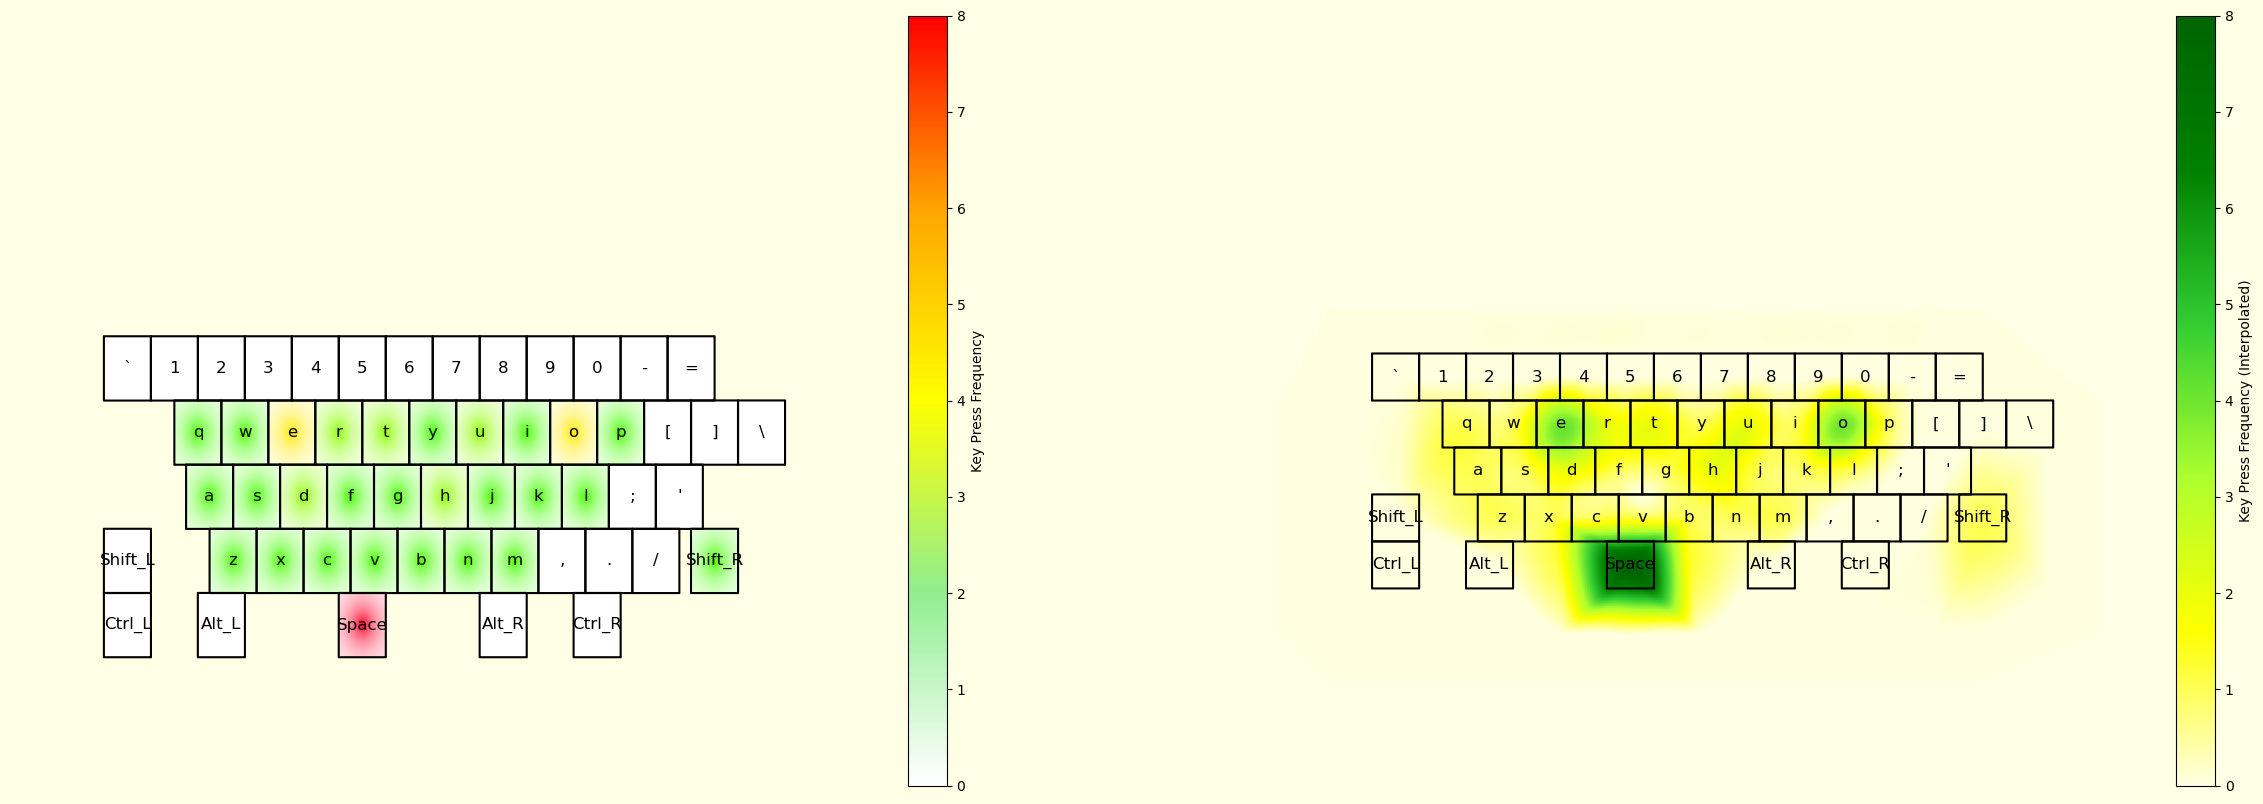

Input String is: The quick brown fox jumped over the lazy dogs
Distance Travelled is 50.24426306573193 units


In [287]:
heatmap=update_heatmap(input_string)
distance_travelled=distance_calculation(input_string)
draw_keyboards(heatmap)
print(f"Input String is: {input_string}")
print(f"Distance Travelled is {distance_travelled} units")

This is an example of an input I generated, a split keyboard.
Run this only if "split_keyboard.py" is in the same directory

Note : For some inputs, the second keyboard may look very weird, Please ignore if it does so and use the first keyboard.

You can modify the input string if you wish to

In [288]:
import split_keyboard as split_keyboard
keys=split_keyboard.keys
characters=split_keyboard.characters

Input String is: The quick brown fox jumped over the lazy dogs
Distance Travelled is 81.07515122731313 units


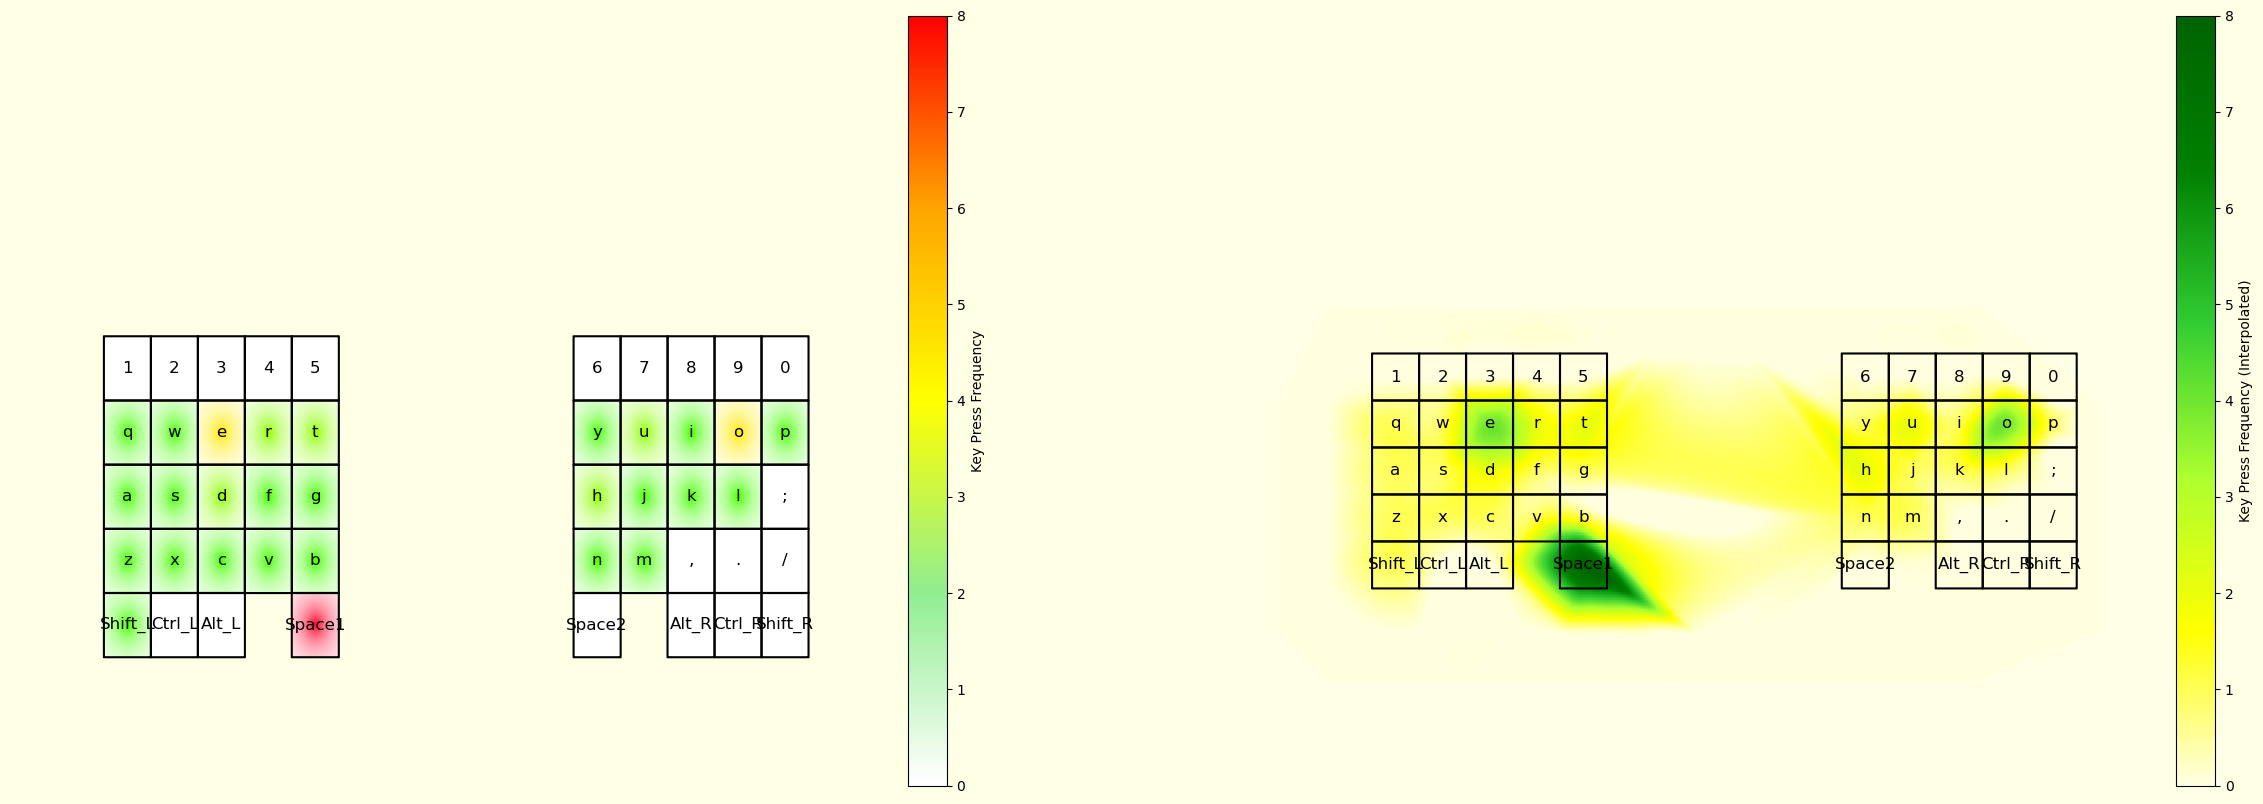

In [289]:
input_string="The quick brown fox jumped over the lazy dogs"
heatmap=update_heatmap(input_string)
distance_travelled=distance_calculation(input_string)
print(f"Input String is: {input_string}")
print(f"Distance Travelled is {distance_travelled} units")
draw_keyboards(heatmap)